In [6]:
import sqlite3

In [7]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [8]:
# connect to the SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('image_metadata.db')
c = conn.cursor()

In [9]:
# get image metadata from the database
c.execute("SELECT file_path, file_name, caption, tags FROM images")  
data = c.fetchall()

In [10]:
# separate the file_paths, file_names, captions, and tags
file_paths = [row[0] for row in data]
file_names = [row[1] for row in data]
captions = [row[2] for row in data]
tags = [row[3] for row in data]

In [ ]:
# combine captions and tags into a single list of documents
documents = [f"{caption} {tag}" for caption, tag in zip(captions, tags)]

In [ ]:
# create a TfidfVectorizer and fit it to the documents
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)

In [ ]:
def find_similar_images(query, threshold=0.1):
    # vectorize the query
    query_vec = vectorizer.transform([query])
    
    # calculate cosine similarities between the query and the documents
    similarities = cosine_similarity(query_vec, X).flatten()
    
    # get indices of images above the threshold
    above_threshold_indices = [i for i, score in enumerate(similarities) if score > threshold]
    
    # print out the file paths of the images above the threshold
    for index in above_threshold_indices:
        print(f"File name: {file_names[index]}, File path: {file_paths[index]}, Similarity: {similarities[index]}")

In [ ]:
# prompt the user to enter a query and run the similarity search
query = "chair in a lawn"
find_similar_images(query)

In [ ]:
import numpy as np
from numpy.linalg import norm
from sentence_transformers import SentenceTransformer

In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
image_sentences = captions 
image_embeddings = model.encode(image_sentences)

In [ ]:
# Define our distance metric
def cosine_similarity(a, b):
    return np.dot(a, b)/(norm(a)*norm(b))
def find_similar_images(query, threshold=0.3):
    # vectorize the query using SentenceTransformer
    query_embedding = model.encode([query])[0]
    
    # calculate cosine similarities between the query and the image embeddings
    similarities = [cosine_similarity(query_embedding, image_embedding) for image_embedding in image_embeddings]
    
    # get indices of images above the threshold
    above_threshold_indices = [i for i, score in enumerate(similarities) if score > threshold]
    
    # print out the file paths of the images above the threshold
    for index in above_threshold_indices:
        print(f"File name: {file_names[index]}, File path: {file_paths[index]}, Similarity: {similarities[index]}")

In [ ]:
query = "chair in a lawn"
find_similar_images(query)

----

# CLIP

In [ ]:
from PIL import Image
import torch
import clip
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
text = clip.tokenize(["black and white"]).to(device)

In [ ]:
# Prepare the image
images = [Image.open(path) for path in file_paths]
image_input = torch.stack([preprocess(img) for img in images]).to(device)

In [ ]:
# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text)

In [ ]:
# Assume threshold
threshold = 0.23

# Calculate cosine similarity
similarity_scores = F.cosine_similarity(text_features, image_features)

# Create a mask for scores above the threshold
mask = similarity_scores > threshold

# Use the mask to get the scores and indices above the threshold
above_threshold_scores = similarity_scores[mask]
above_threshold_indices = torch.nonzero(mask).flatten()

# Print the scores and corresponding image paths above the threshold
for score, index in zip(above_threshold_scores, above_threshold_indices):
    image_path = file_paths[index]
    print(f"Similarity between text and {image_path}: {score.item()}")

    # Show the image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # do not show axis value
    plt.show()

----

# OPEN CLIP

In [15]:
import torch
import torch.nn.functional as F
from PIL import Image
import open_clip
import matplotlib.pyplot as plt

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k', device=device)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

In [18]:
tokenizer = open_clip.get_tokenizer('ViT-B-32')

In [23]:
# Prepare the image
images = torch.stack([preprocess(Image.open(path)) for path in file_paths]).to(device)

In [24]:
text = tokenizer(["man and woman"]).to(device)

In [25]:
with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(images)
    text_features = model.encode_text(text)

    # Normalize the features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

Similarity between text and D:\AIML\gimmick\Scene-Sense\test100\laion2b_en_part_00000_000243.png: 0.2225341796875


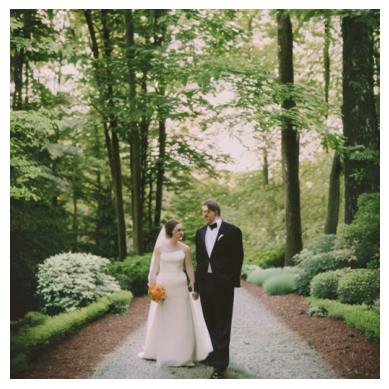

Similarity between text and D:\AIML\gimmick\Scene-Sense\test100\laion2b_en_part_00001_000714.png: 0.2100830078125


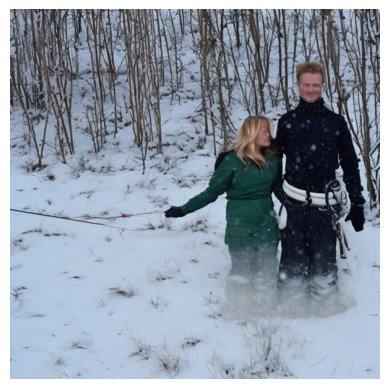

In [26]:
# Calculate cosine similarity
similarity_scores = F.cosine_similarity(text_features, image_features)

# Assume threshold
threshold = 0.21

# Create a mask for scores above the threshold
mask = similarity_scores > threshold

# Use the mask to get the scores and indices above the threshold
above_threshold_scores = similarity_scores[mask]
above_threshold_indices = torch.nonzero(mask).flatten()

# Print the scores and corresponding image paths above the threshold
for score, index in zip(above_threshold_scores, above_threshold_indices):
    image_path = file_paths[index]
    print(f"Similarity between text and {image_path}: {score.item()}")

    # Show the image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # do not show axis value
    plt.show()